# Logic Regression

## Through write function to get logic regression

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

### Generation Datasets

In [2]:
def tensorGenCla(num_examples=500, num_inputs=2, num_class=3, deg_dispersion=[4, 2], bias=False):
    """分类数据集创建函数。

    :param num_examples: 每个类别的数据数量
    :param num_inputs: 数据集特征数量
    :param num_class：数据集标签类别总数
    :param deg_dispersion：数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考、第二个参数表示随机数组标准差。
    :param bias：建立模型逻辑回归模型时是否带入截距
    :return: 生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组。
    """

    cluster_l = torch.empty(num_examples, 1)  # 每一类标签张量的形状
    mean_ = deg_dispersion[0]  # 每一类特征张量的均值的参考值
    std_ = deg_dispersion[1]  # 每一类特征张量的方差
    lf = []  # 用于存储每一类特征张量的列表容器
    ll = []  # 用于存储每一类标签张量的列表容器
    k = mean_ * (num_class - 1) / 2  # 每一类特征张量均值的惩罚因子（视频中部分是+1，实际应该是-1）

    for i in range(num_class):
        data_temp = torch.normal(
            i * mean_ - k, std_, size=(num_examples, num_inputs))  # 生成每一类张量
        lf.append(data_temp)  # 将每一类张量添加到lf中
        labels_temp = torch.full_like(cluster_l, i)  # 生成类一类的标签
        ll.append(labels_temp)  # 将每一类标签添加到ll中

    features = torch.cat(lf).float()
    labels = torch.cat(ll).long()

    if bias == True:
        features = torch.cat((features, torch.ones(
            len(features), 1)), 1)  # 在特征张量中添加一列全是1的列
    return features, labels

In [3]:
torch.manual_seed(420)
features, labels = tensorGenCla(num_class=2, bias=True)

### Build Module

### Select model

- activation function

In [4]:
def sigmoid(z):
    return 1/(1+torch.exp(-z))

- logical regression model

In [5]:
def logistic(X, w):
    return sigmoid(torch.mm(X, w))

In [6]:
def cal(sigma, p=0.5):
    return((sigma >= p).float())

In [12]:
def accuracy(sigma, y):
    acc_bool = cal(sigma).flatten() == y.flatten()
    acc = torch.mean(acc_bool.float())
    return(acc)

### loss function

In [8]:
def cross_entropy(sigma, y):
    return(-(1/y.numel())*torch.sum((1-y)*torch.log(1-sigma)+y*torch.log(sigma)))

### optim

In [9]:
def sgd(params, lr):
    params.data -= lr*params.grad
    params.grad.zero_()

### train

In [10]:
def data_iter(batch_size, features, labels):
    """
    数据切分函数

    :param batch_size: 每个子数据集包含多少数据
    :param featurs: 输入的特征张量
    :param labels：输入的标签张量
    :return l：包含batch_size个列表，每个列表切分后的特征和标签所组成
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    l = []
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        l.append([torch.index_select(features, 0, j),
                 torch.index_select(labels, 0, j)])
    return l

In [13]:
torch.manual_seed(420)

batch_size = 10
lr = 0.03
num_epochs = 3
w = torch.ones(3, 1, requires_grad=True)

net = logistic
loss = cross_entropy

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w), y)
        l.backward()
        sgd(w, l)
    train_acc = accuracy(net(features, w), labels)
    print('epoch %d, accuracy %f' % (epoch + 1, train_acc))

epoch 1, accuracy 0.914000
epoch 2, accuracy 0.919000
epoch 3, accuracy 0.913000


### tune models

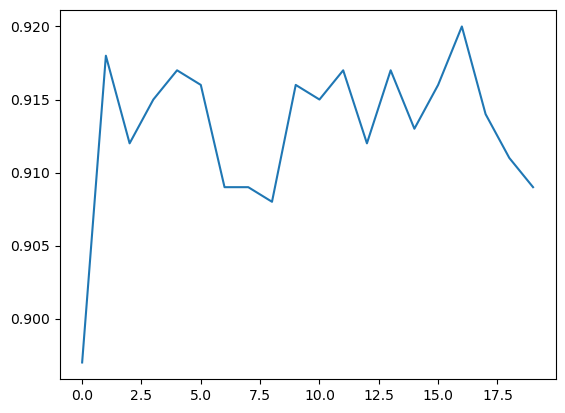

In [15]:
torch.manual_seed(420)

num_epochs = 20

w = torch.ones(3, 1, requires_grad=True)

train_acc = []

for i in range(num_epochs):
    for epoch in range(i):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w), y)
            l.backward()
            sgd(w, l)
    train_acc.append(accuracy(net(features, w), labels))

plt.plot(list(range(num_epochs)), train_acc)

## Using Pytoch

In [17]:
batch_size = 10
lr = 0.03
num_epochs = 3

torch.manual_seed(420)

features,labels = tensorGenCla(num_class=2)
labels = labels.float()
data = TensorDataset(features,labels)
databatch = DataLoader(data,batch_size=batch_size,shuffle=True)


class logisticR(nn.Module):
    def __init__(self,in_features=2,out_features=1):
        super(logisticR,self).__init__()
        self.linear = nn.Linear(in_features,out_features)
    def forward(self,x):
        out = self.linear(x)
        return out
    
logic_model = logisticR()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(logic_model.parameters(), lr=lr)

def fit(net, criterion, optimizer,batchdata,epochs):
    for epoch in range(epochs):
        for X,y in batchdata:
            zhat = net.forward(X)
            loss = criterion(zhat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
torch.manual_seed(420)

fit(net=logic_model,
   criterion=criterion,
   optimizer=optimizer,
   batchdata=databatch,
   epochs=num_epochs)

In [18]:
def acc_zhat(zhat,y):
    sigma = sigmoid(zhat)
    return accuracy(sigma,y)

acc_zhat(logic_model(features),labels)

tensor(0.9130)

In [19]:
#创建数据
torch.manual_seed(420)   

features, labels = tensorGenCla(num_class=2)                     
labels = labels.float()                           
data = TensorDataset(features, labels)            
batchData = DataLoader(data, batch_size = batch_size, shuffle = True)

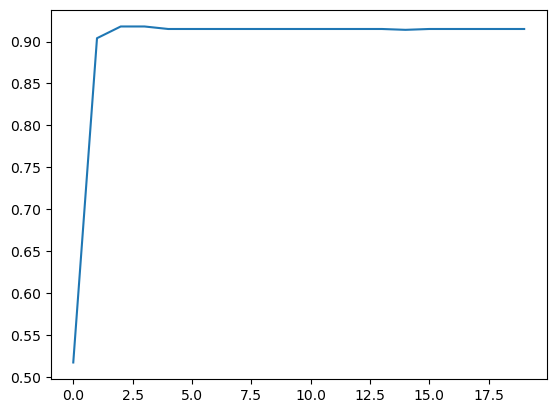

In [20]:
# 设置随机数种子
torch.manual_seed(420)  

# 初始化核心参数
num_epochs = 20
LR1 = logisticR()
cr1 = nn.BCEWithLogitsLoss()
op1 = optim.SGD(LR1.parameters(), lr = lr)

# 创建列表容器
train_acc = []

# 执行建模
for epochs in range(num_epochs):
    fit(net = LR1, 
        criterion = cr1, 
        optimizer = op1, 
        batchdata = batchData, 
        epochs = epochs)
    epoch_acc = acc_zhat(LR1(features), labels)
    train_acc.append(epoch_acc)

# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)